Pipeline Draft

There are three types of tags in this assignment:
<br>
1) Weather (Cloudly, Partly Cloudy, Hazy, Clear) - every item has only one of these ones
<br>
2) Easy to identify tags Primary (forest), agricultural, habitation, roads, water, cultivation, bare ground,
<br>
3) Hard Labels - Slash & Burn, selective logging, blooms, and mine types
<br>

For the base submission we will try to classify the first and second types and leave hard labels to the full submission

Overview of summary:
1) Exploratory Data Analysis - Elle/Wei
<br>
2) Image Processing and Extraction - Elle/Sai
<br>
3) Weather Prediction Attempts- Wei
<br>
3) Land Type Prediction Attempts Nick/Sai
<br>
4) Try CNNs (this is for stage 2)

5) Build a clean pipe-line per June's comment - Nick
<br>
Take the time in the beginning to make it easy to swap in and out models. This can be done a few ways. Either with helper functions inside a main notebook, or by breaking the project up into stages of pre-processing, ship the pre-processed data to each of the models, then the models ship back the predictions to a final step. But have a think through in the beginning how to set this up so that folks can simultaneously work on different models at the same time.

<br>



In [2]:
##Create Libraries
### Required libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from subprocess import check_output
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import bernoulli
import seaborn as sns
import cv2
# from osgeo import gdal
from skimage import io
from spectral import get_rgb
from spectral import ndvi
from sklearn import preprocessing
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from skimage import transform
from sklearn.tree import DecisionTreeClassifier



C:\Users\nmccorma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\nmccorma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
##set directories path
train_path1='train_jpg/'
train_path2='train_tif/'
test_path1='test_jpg/'
print(test_path1)
df = pd.read_csv('train_labels.csv')

test_jpg/


EDA
1) Things to do show variety of images (Done - Elle)
<br>
2) Show the size of the seth
<br>
2) Show volume of labels (Done - Elle) in a graph form
<br>
3) Show Correlation between Labels (Wei)
<br>
4) Create Secondary sets of labels with only easy labels, and only weather labels - Elle Done
<br>

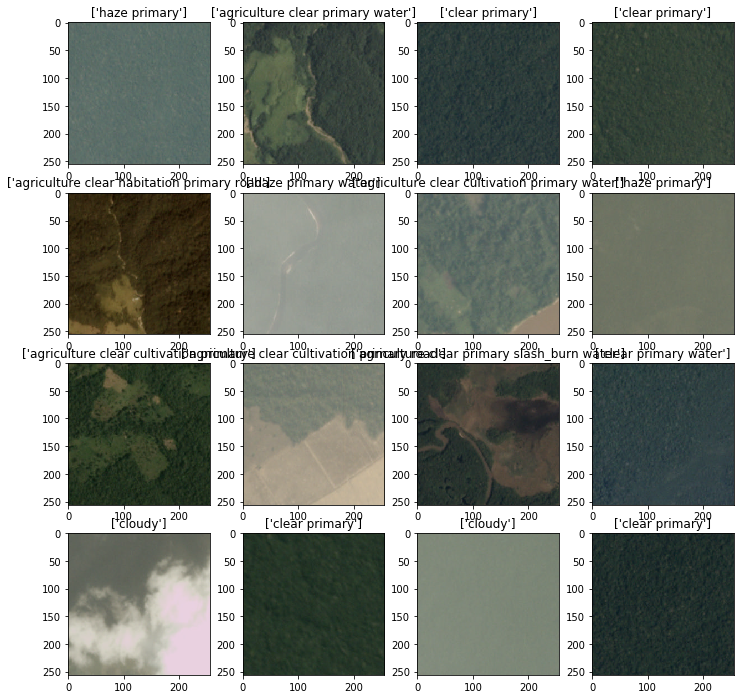

In [4]:
plt.figure(figsize=(12,12))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(plt.imread(train_path1+'train_'+str(i)+'.jpg'))
    plt.title(str(df[df.image_name == 'train_'+str(i)].tags.values))

total of 116278 non-unique tags in all training images
average number of labels per image 2.8725511993873365 

There is 17 unique labels including {'road', 'cultivation', 'water', 'blooming', 'blow_down', 'partly_cloudy', 'artisinal_mine', 'habitation', 'agriculture', 'bare_ground', 'clear', 'cloudy', 'conventional_mine', 'selective_logging', 'haze', 'slash_burn', 'primary'} 



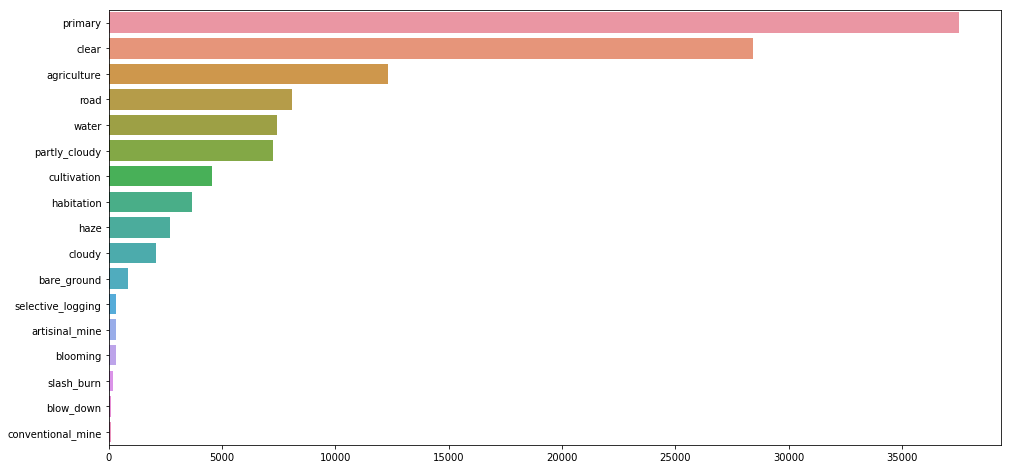

In [5]:
## View prominent tags and investigate correlations

df = pd.read_csv('train_labels.csv')

all_tags = [item for sublist in list(df['tags'].apply(lambda row: row.split(" ")).values) for item in sublist]


print('total of {} non-unique tags in all training images'.format(len(all_tags)))
print('average number of labels per image {} \n'.format(1.0*len(all_tags)/df.shape[0]))

labels_set = set(all_tags)
print("There is {} unique labels including {} \n".format(len(labels_set), labels_set))

labels_s = pd.Series(all_tags).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')

In [109]:
from collections import defaultdict
import plotly.plotly as py
import plotly.graph_objs as go
#Display correlation between labels
labels = df['tags'].apply(lambda x: x.split(' '))
counts = defaultdict(int)
for l in labels:
    for l2 in l:
        counts[l2] += 1

com = np.zeros([len(counts)]*2)
for i, l in enumerate(list(counts.keys())):
    for i2, l2 in enumerate(list(counts.keys())):
        c = 0
        cy = 0
        for row in labels.values:
            if l in row:
                c += 1
                if l2 in row: cy += 1
        com[i, i2] = cy / c

data=[go.Heatmap(z=com, x=list(counts.keys()), y=list(counts.keys()))]
layout=go.Layout(height=800, width=800, title='Co-occurence matrix of training labels')
fig=dict(data=data, layout=layout)
py.iplot(data, filename='train-com')

Aw, snap! We didn't get a username with your request.

Don't have an account? https://plot.ly/api_signup

Questions? accounts@plot.ly


PlotlyError: Because you didn't supply a 'file_id' in the call, we're assuming you're trying to snag a figure from a url. You supplied the url, '', we expected it to start with 'https://plot.ly'.
Run help on this function for more information.

In [ ]:
##Simple Problems
def apply_weather(weather):
    if 'partly_cloudy' in weather:
        return 'partly_cloudy'
    elif 'cloudy' in weather:
        return 'cloudy'
    elif 'haze' in weather:
        return 'haze'
    else:
        return 'clear'
df['weather'] = df.tags.map(apply_weather)
df_tags = df['weather'].tolist()

#Remove hard tags
def remove_tag(hard):
    hard_tags=['blow_down', 'conventional_mine', 'selective_logging', 'slash_burn', 'artisinal_mine', 'blooming']
    easier_tags=hard.split()
    for i in hard_tags:
        try:
            easier_tags.remove(i)
        except:
            pass
    easier_tags=' '.join(easier_tags)
    return easier_tags
df['simpler_tags'] = df.tags.map(remove_tag)

test_labels=np.array(df[15000:20000])
train_labels=np.array(df[:15000])

In [118]:
df.loc[df['tags']!=df['simpler_tags'],].head()

image_name                                               tags  \
10   train_10         agriculture clear primary slash_burn water   
24   train_24            conventional_mine partly_cloudy primary   
57   train_57     artisinal_mine bare_ground clear primary water   
70   train_70                             blooming clear primary   
82   train_82  blooming clear cultivation habitation primary ...   

          weather                          simpler_tags  
10          clear       agriculture clear primary water  
24  partly_cloudy                 partly_cloudy primary  
57          clear       bare_ground clear primary water  
70          clear                         clear primary  
82          clear  clear cultivation habitation primary

In [126]:
###Question about this...

print("There are total {} weather data".format(len(df_tags)))
import random
#Read images and resize to reduce size
weather_jpgs=[]
def read_image(image_str):
    jpg_img = io.imread(train_path1+image_str)
    print(train_path1+image_str)
    norm_img=jpg_img/255
    norm_img=transform.resize(norm_img, (50,50,3))
    return norm_img.flatten()
for i in range(5000):
    weather_jpgs.append(read_image("train_"+str(i)+".jpg"))

    
##Question Here...
#Set the first 30K data as training data, the rest as test data
train_labels=np.array(df_tags[:30000])
train_data=weather_jpgs[:30000]

test_labels=np.array(df_tags[30000:])
test_data=weather_jpgs[30000:]

#Random pick 10000 samples for training data
index_value = random.sample(list(enumerate(train_data)), 1000)
indexes = []
train_data_sample = []
for idx, val in index_value:
    indexes.append(idx)
    train_data_sample.append(val)

train_label_sample =[]
for i in indexes:
    train_label_sample.append(train_labels[i])

There are total 40479 weather data
train_jpg/train_0.jpg
train_jpg/train_1.jpg
train_jpg/train_2.jpg
train_jpg/train_3.jpg
train_jpg/train_4.jpg
train_jpg/train_5.jpg
train_jpg/train_6.jpg
train_jpg/train_7.jpg
train_jpg/train_8.jpg
train_jpg/train_9.jpg
train_jpg/train_10.jpg
train_jpg/train_11.jpg
train_jpg/train_12.jpg
train_jpg/train_13.jpg
train_jpg/train_14.jpg
train_jpg/train_15.jpg
train_jpg/train_16.jpg
train_jpg/train_17.jpg
train_jpg/train_18.jpg
train_jpg/train_19.jpg
train_jpg/train_20.jpg
train_jpg/train_21.jpg
train_jpg/train_22.jpg
train_jpg/train_23.jpg
train_jpg/train_24.jpg
train_jpg/train_25.jpg
train_jpg/train_26.jpg
train_jpg/train_27.jpg
train_jpg/train_28.jpg
train_jpg/train_29.jpg
train_jpg/train_30.jpg


C:\Users\nmccorma\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning:

The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.



train_jpg/train_31.jpg
train_jpg/train_32.jpg
train_jpg/train_33.jpg
train_jpg/train_34.jpg
train_jpg/train_35.jpg
train_jpg/train_36.jpg
train_jpg/train_37.jpg
train_jpg/train_38.jpg
train_jpg/train_39.jpg
train_jpg/train_40.jpg
train_jpg/train_41.jpg
train_jpg/train_42.jpg
train_jpg/train_43.jpg
train_jpg/train_44.jpg
train_jpg/train_45.jpg
train_jpg/train_46.jpg
train_jpg/train_47.jpg
train_jpg/train_48.jpg
train_jpg/train_49.jpg
train_jpg/train_50.jpg
train_jpg/train_51.jpg
train_jpg/train_52.jpg
train_jpg/train_53.jpg
train_jpg/train_54.jpg
train_jpg/train_55.jpg
train_jpg/train_56.jpg
train_jpg/train_57.jpg
train_jpg/train_58.jpg
train_jpg/train_59.jpg
train_jpg/train_60.jpg
train_jpg/train_61.jpg
train_jpg/train_62.jpg
train_jpg/train_63.jpg
train_jpg/train_64.jpg
train_jpg/train_65.jpg
train_jpg/train_66.jpg
train_jpg/train_67.jpg
train_jpg/train_68.jpg
train_jpg/train_69.jpg
train_jpg/train_70.jpg
train_jpg/train_71.jpg
train_jpg/train_72.jpg
train_jpg/train_73.jpg
train_jpg/t

train_jpg/train_403.jpg
train_jpg/train_404.jpg
train_jpg/train_405.jpg
train_jpg/train_406.jpg
train_jpg/train_407.jpg
train_jpg/train_408.jpg
train_jpg/train_409.jpg
train_jpg/train_410.jpg
train_jpg/train_411.jpg
train_jpg/train_412.jpg
train_jpg/train_413.jpg
train_jpg/train_414.jpg
train_jpg/train_415.jpg
train_jpg/train_416.jpg
train_jpg/train_417.jpg
train_jpg/train_418.jpg
train_jpg/train_419.jpg
train_jpg/train_420.jpg
train_jpg/train_421.jpg
train_jpg/train_422.jpg
train_jpg/train_423.jpg
train_jpg/train_424.jpg
train_jpg/train_425.jpg
train_jpg/train_426.jpg
train_jpg/train_427.jpg
train_jpg/train_428.jpg
train_jpg/train_429.jpg
train_jpg/train_430.jpg
train_jpg/train_431.jpg
train_jpg/train_432.jpg
train_jpg/train_433.jpg
train_jpg/train_434.jpg
train_jpg/train_435.jpg
train_jpg/train_436.jpg
train_jpg/train_437.jpg
train_jpg/train_438.jpg
train_jpg/train_439.jpg
train_jpg/train_440.jpg
train_jpg/train_441.jpg
train_jpg/train_442.jpg
train_jpg/train_443.jpg
train_jpg/train_

train_jpg/train_773.jpg
train_jpg/train_774.jpg
train_jpg/train_775.jpg
train_jpg/train_776.jpg
train_jpg/train_777.jpg
train_jpg/train_778.jpg
train_jpg/train_779.jpg
train_jpg/train_780.jpg
train_jpg/train_781.jpg
train_jpg/train_782.jpg
train_jpg/train_783.jpg
train_jpg/train_784.jpg
train_jpg/train_785.jpg
train_jpg/train_786.jpg
train_jpg/train_787.jpg
train_jpg/train_788.jpg
train_jpg/train_789.jpg
train_jpg/train_790.jpg
train_jpg/train_791.jpg
train_jpg/train_792.jpg
train_jpg/train_793.jpg
train_jpg/train_794.jpg
train_jpg/train_795.jpg
train_jpg/train_796.jpg
train_jpg/train_797.jpg
train_jpg/train_798.jpg
train_jpg/train_799.jpg
train_jpg/train_800.jpg
train_jpg/train_801.jpg
train_jpg/train_802.jpg
train_jpg/train_803.jpg
train_jpg/train_804.jpg
train_jpg/train_805.jpg
train_jpg/train_806.jpg
train_jpg/train_807.jpg
train_jpg/train_808.jpg
train_jpg/train_809.jpg
train_jpg/train_810.jpg
train_jpg/train_811.jpg
train_jpg/train_812.jpg
train_jpg/train_813.jpg
train_jpg/train_

train_jpg/train_1142.jpg
train_jpg/train_1143.jpg
train_jpg/train_1144.jpg
train_jpg/train_1145.jpg
train_jpg/train_1146.jpg
train_jpg/train_1147.jpg
train_jpg/train_1148.jpg
train_jpg/train_1149.jpg
train_jpg/train_1150.jpg
train_jpg/train_1151.jpg
train_jpg/train_1152.jpg
train_jpg/train_1153.jpg
train_jpg/train_1154.jpg
train_jpg/train_1155.jpg
train_jpg/train_1156.jpg
train_jpg/train_1157.jpg
train_jpg/train_1158.jpg
train_jpg/train_1159.jpg
train_jpg/train_1160.jpg
train_jpg/train_1161.jpg
train_jpg/train_1162.jpg
train_jpg/train_1163.jpg
train_jpg/train_1164.jpg
train_jpg/train_1165.jpg
train_jpg/train_1166.jpg
train_jpg/train_1167.jpg
train_jpg/train_1168.jpg
train_jpg/train_1169.jpg
train_jpg/train_1170.jpg
train_jpg/train_1171.jpg
train_jpg/train_1172.jpg
train_jpg/train_1173.jpg
train_jpg/train_1174.jpg
train_jpg/train_1175.jpg
train_jpg/train_1176.jpg
train_jpg/train_1177.jpg
train_jpg/train_1178.jpg
train_jpg/train_1179.jpg
train_jpg/train_1180.jpg
train_jpg/train_1181.jpg


train_jpg/train_1504.jpg
train_jpg/train_1505.jpg
train_jpg/train_1506.jpg
train_jpg/train_1507.jpg
train_jpg/train_1508.jpg
train_jpg/train_1509.jpg
train_jpg/train_1510.jpg
train_jpg/train_1511.jpg
train_jpg/train_1512.jpg
train_jpg/train_1513.jpg
train_jpg/train_1514.jpg
train_jpg/train_1515.jpg
train_jpg/train_1516.jpg
train_jpg/train_1517.jpg
train_jpg/train_1518.jpg
train_jpg/train_1519.jpg
train_jpg/train_1520.jpg
train_jpg/train_1521.jpg
train_jpg/train_1522.jpg
train_jpg/train_1523.jpg
train_jpg/train_1524.jpg
train_jpg/train_1525.jpg
train_jpg/train_1526.jpg
train_jpg/train_1527.jpg
train_jpg/train_1528.jpg
train_jpg/train_1529.jpg
train_jpg/train_1530.jpg
train_jpg/train_1531.jpg
train_jpg/train_1532.jpg
train_jpg/train_1533.jpg
train_jpg/train_1534.jpg
train_jpg/train_1535.jpg
train_jpg/train_1536.jpg
train_jpg/train_1537.jpg
train_jpg/train_1538.jpg
train_jpg/train_1539.jpg
train_jpg/train_1540.jpg
train_jpg/train_1541.jpg
train_jpg/train_1542.jpg
train_jpg/train_1543.jpg


KeyboardInterrupt: 

Image Processing for weather prediction:
1) Work out how to reduce image sizes - everybody ()
<br>
2) Move, Shape, Blend, Rotate
<br>
3) Try Statistical Extraction 
Maybe this is a good approach to extract stats - we can add our road information into it:
https://www.kaggle.com/the1owl/fractals-of-nature-blend-0-90050
<br>
<br>
<br>
4) Try Feature Extraction :
<br>
Roads/ Houses via Canny edging - Sai
Water and Vegetation - Elle
Cloud - Elle
Haze removal - Elle


Now - let's look at the TIF images, which also contain infrared information. 
This is helpful because it contains infrared light which helps us identify 
Essentially we can tell if something is likely to be water by substracting the 
infrared light from the blue light, and dividing by sum.

The same can be said for vegetation. 

The two formulas are
(B-IRR)/(B+IRR) = index for water
(R-IRR)/(R+IRR) = index for vegetation

In [129]:
count = 0
for i in os.listdir(train_path2):
    count+=1

C:\Users\nmccorma\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning:

The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.

C:\Users\nmccorma\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\nmccorma\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

invalid value encountered in true_divide



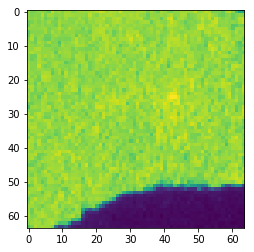

In [130]:
np.seterr(all='warn')
def extract_identifier(image_str):
    read_img = io.imread(train_path2+image_str)
    tif_img=transform.resize(read_img, (64,64,4))
    return tif_img

tif_data=np.zeros((count,64,64,4))
index=0
for i in range(41000):
    try:
        tif_data[index,:,:,:]=extract_identifier("train_"+str(i)+".tif")
        index+=1
    except:
        pass
water_tif=(tif_data[:,:,:,0]-tif_data[:,:,:,3])/(tif_data[:,:,:,0]+tif_data[:,:,:,3])
veg_tif=(tif_data[:,:,:,3]-tif_data[:,:,:,2])/(tif_data[:,:,:,3]+tif_data[:,:,:,2]) 
new_tif= tif_data.reshape(count,16384)
plt.imshow(water_tif[50])
plt.imshow(veg_tif[50])

In [21]:
#plt.imshow(water_tif[50])
water_tif[2]

array([[-0.3547892 , -0.33897886, -0.3293237 , ..., -0.35608797,
        -0.34364611, -0.31210957],
       [-0.22640695, -0.29674676, -0.33176739, ..., -0.36309457,
        -0.26838226, -0.37404682],
       [-0.16813909, -0.42236904, -0.34097788, ..., -0.34590969,
        -0.36298867, -0.34713331],
       ...,
       [-0.3004434 , -0.27116805, -0.19397175, ..., -0.26807476,
        -0.20157241, -0.09608424],
       [-0.3287726 , -0.19984612, -0.25497604, ..., -0.20744299,
        -0.2141629 , -0.16825252],
       [-0.22546094, -0.16203772, -0.27052905, ..., -0.28062817,
        -0.24944987, -0.26043165]])

In [23]:
##extract Variation statistics from trees
#count=40000
land_props=np.zeros((count,50))
for i in range(count):
    land_props[i,:]=np.array(np.histogram(veg_tif[i],bins=50, range=(-1,1))[0])
water_props=np.zeros((count,50))
for i in range(count):
    water_props[i,:]=np.array(np.histogram(water_tif[i],bins=50, range=(-1,1))[0])
print(water_props)
combined_matrix=np.zeros((count,100))
combined_matrix[:,0:50]=land_props
combined_matrix[:,50:100]=water_props

C:\Users\nmccorma\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\nmccorma\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [24]:
print(tif_data[1].shape)

(64, 64, 4)


In [25]:
##read weather J-pegs
weather_jpgs=np.zeros((count,64,64,3))
def read_image(image_str):
    read_img = plt.imread(train_path1+image_str)
    read_img=read_img[:,:,:3]
    jpg_img=transform.resize(read_img, (64,64,3))
    return jpg_img
for i in range(count):
    weather_jpgs[i,:,:,:]=read_image("train_"+str(i)+".jpg")
    #if i % 100 ==0:
        #print(i)


C:\Users\nmccorma\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000


In [42]:
##extract_basic-stats
stats_flat=np.reshape(weather_jpgs,(weather_jpgs.shape[0],4096,3))
jpg_stats=np.zeros((stats_flat.shape[0],9))
jpg_stats

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [81]:
##extract_basic-stats
stats_flat=np.reshape(weather_jpgs,(weather_jpgs.shape[0],4096,3))
jpg_stats=np.zeros((stats_flat.shape[0],9))
for i in range(stats_flat.shape[0]-1):
    #jpg_stats[i,0:3]=np.average(weather_flat[i],axis=0)
    #jpg_stats[i,3:6]=np.var(waether_flat[i],axis=0)
    #jpg_stats[i,3:9]=np.std(weather_flat[i],axis=0)
    jpg_stats[i,0:3]=np.average(stats_flat[i],axis=0)
    jpg_stats[i,3:6]=np.var(stats_flat[i],axis=0)
    jpg_stats[i,6:9]=np.std(stats_flat[i],axis=0)

matrix_for_analysis=np.zeros((count,109))
matrix_for_analysis[:,:100]=combined_matrix
matrix_for_analysis[:,100:]=jpg_stats

In [96]:
#Land: 0:50
#Water: 50:100
#Avg: 100:103
#Variance: 103:106
#Std Dev: 106:109
matrix_for_analysis

0.03571465422339613

3) Try these models (this needs to be on the processed numbers) - Sai/Nick
OneVsRestClassifier
https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Multi%20label%20text%20classification.ipynb

K-NN
Naive Bayes
Decision Trees
Random forests
Logistic Regression
Binary Relevance Chain 
Gaussian NB
Logsitic Regression

K-NN
Naive Bayes
Decision Trees
Random forests
Logistic Regression

Classifier CHains 
Gaussian NB
Logsitic Regression

K-NN
Naive Bayes
Decision Trees
Random forests
Logistic Regression
Adapted Algorithms
Multi-label nearest Neigbors
Decisions Trees
Random Forests
Neural Nets



Image Processing - how do we make the images smaller, easier size agnostic

In [ ]:
Weather Models

test_labels=df_tags[15000:20000]
train_labels=df_tags[:15000]
train_data=water_shape[:15000]
test_data=water_shape[15000:20000]

##Model Prediction - run variety of models to identify weather, using model extraction - run a bunch of models here. 
##Work out how better to separate partly cloudy - perhaps a count for cloudy pixels

def dec_tree_model(maxs,data_train,labels_train,data_test,labels_test):
    #set the model to take in the k value
    model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=maxs)
    #fit per the train data
    model.fit(data_train, labels_train)
    dev_predictions2=model.predict(data_test)
    #set by the test data
#     score = model.score(data_test, labels_test)
    #print the score prettily
    return classification_report(labels_test,dev_predictions2)

#print eveyrhting
print("dev data sets")
for i in [5,10,20,50,100]:
    print(dec_tree_model(i,train_data,train_labels,test_data,test_labels))

In [ ]:
def k_model(k,data_train,labels_train,data_test,labels_test):
    #set the model to take in the k value
    model = KNeighborsClassifier(n_neighbors=k)
    #fit per the train data
    model.fit(data_train, labels_train)
    #set by the test data
    score = model.score(data_test, labels_test)
    #print the score prettily
    return (str(k)+"-NN model score: "+	str("{:.2%}".format(score)))

k_values = [1, 3]

#print eveyrhting
print("dev data sets")
for k in k_values:
    print(k_model(k,train_data,train_labels,test_data,test_labels))

In [ ]:
def dec_tree_model(maxs,data_train,labels_train,data_test,labels_test):
    #set the model to take in the k value
    model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=maxs)
    #fit per the train data
    model.fit(data_train, labels_train)
    dev_predictions2=model.predict(data_test)
    #set by the test data
#     score = model.score(data_test, labels_test)
    #print the score prettily
    return classification_report(labels_test,dev_predictions2)

for i in [5,10,20,50]:
    print(dec_tree_model(i,train_data,train_labels,test_data,test_labels))

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.metrics import fbeta_score
dim=20
df['tags_split'] = df['tags'].map(lambda row: row.split(" "))
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['tags_split'])
X = np.squeeze(np.array([cv2.resize(plt.imread(train_path1+'{}.jpg'.format(name)), (dim, dim), cv2.INTER_LINEAR).reshape(1, -1) for name in df['image_name'].values]))
X = MinMaxScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
OneVsRestClassifier(LogisticRegression()).fit(X_train, y_train).predict(X_test)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
ovr=OneVsRestClassifier(LogisticRegression()).fit(X_train, y_train)
score = fbeta_score(y_test, ovr.predict(X_test), beta=2, average=None)
avg_sample_score = fbeta_score(y_test, ovr.predict(X_test), beta=2, average='samples')
print('F2 test score (avg) {}'.format(avg_sample_score))

Out of scope
Try Convultional Neural Networks
Ask June for help in Set-up